# Optimization and Mixed-Language Programming

So far, we have discussed [optimization](software_optimization.md) in general. Recall some of the main points:
* First, make it work. Then, make it right. Lastly, make it fast.
* *Profile* the code to identify bottlenecks.

In this chapter, we explore some examples of optimization. Remember that optimization will always be problem-specific, so there are no universal general rules. The takeaway shouldn't be the specific examples we show, but more how we can think about the process of optimization as a structured approach. Later, we discuss the possibilities and benefits of mixed-language programming.

## Choosing a Different Algorithm

One major way to optimize a code is to choose a different way to solve the problem, i.e., a different algorithm altogether. Changing the entire algorithm can, depending on the code, be quite a drastic change and is referred to as a high-level optimization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12345)

### Example: Finding unique elements

Consider the problem of given two lists of integers, `x` and `y`, find all unique common elements. For example, given the two lists `x = [1, 2, 3]` and `y = [2, 3, 4]`, we want to find the list `z = [2, 3]`. For testing runtimes of different algorithms, we will use two randomized arrays, both with length 10000.

In [2]:
x = np.random.randint(1, 10000, 10000)
y = np.random.randint(1, 10000, 10000)

A naive function to solve this problem could be implemented as follows.

In [3]:
def find_common_elements1(x, y):
    common_elements = []
    for xi in x:
        for yi in y:
            if xi == yi:
                if xi not in common_elements:
                    common_elements.append(xi)
    return common_elements

```Python
%timeit find_common_values1(x, y)
```
```
9.66 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

This algorithm has a time complexity of $\mathcal{O}(N^2)$, assuming both lists are of length $N$. A better implementation would be removing the second for-loop:

In [4]:
def find_common_elements2(x, y):
    common_elements = []
    for xi in x:
        if xi in y:
            if xi not in common_elements:
                common_elements.append(xi)
    return common_elements

```Python
%timeit find_common_values2(x, y)
```
```
339 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

We see that this change resulted in a large improvement in time. A third way of solving this problem would be the following algorithm.

In [5]:
def find_common_elements3(x, y):
    return list(set(x).intersection(set(y)))

Here, we convert both lists to sets by using the `set()` method, which also removes duplicates. Then, we use `intersection()` to return a set containing the similarity between the two sets and finally convert this back to a list.

```Python
%timeit find_common_values3(x, y)
```
```
3.37 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

Again, we observe a dramatic improvement in runtime. Why? This is because sets are natively implemented in Python with a data structure called [*hash maps*](https://www.geeksforgeeks.org/hashing-data-structure/), which allows certain improvements. For example, checking if an element is in a set has a time complexity of $\mathcal{O}(1)$.

### Choosing an element with weighted probabilities

Say we have a list of objects that is $n$ long, and a vector $\bar{p}$, where $p_i$ denotes the probability of picking element $i$ from the list. Due to the law of total probability, we know that $\sum_i p_i = 1$.

If we want to pick an element from the list with probabilities $\bar{p}$, we can do this with `np.random.choice`.

In [6]:
elements = ['a', 'b', 'c', 'd']
p = (0.1, 0.55, 0.25, 0.1)

print(np.random.choice(elements, p=p))

b


We can also make the same choice by picking a random number in the interval $[0, 1)$, and comparing it to the cumulative probability.

In [7]:
cp = np.cumsum(p)


def pick_element(elements, cp):
    r = np.random.random()
    for i, cpi in enumerate(cp):
        if r < cpi:
            return elements[i]

In [8]:
%timeit -n 1000 np.random.choice(elements)
%timeit -n 1000 pick_element(elements, cp)

23.8 µs ± 3.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.32 µs ± 98.5 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Using our code is more than 4 times faster than the NumPy function. If the process of picking random elements is a major bottleneck, this would mean replacing `np.random.choice` with our function would reduce the total runtime by 75%.

However, suppose we want to do this choice multiple times. This could be implemented by a for-loop:

In [9]:
def pick_n_elements(elements, cp, n):
    choices = []
    for _ in range(n):
        choices.append(pick_element(elements, cp))
    return choices

For `np.random.choice`, we only need to add the `size` parameter.

In [10]:
%timeit -n 1000 np.random.choice(elements, p = p, size = 1000)
%timeit -n 1000 pick_n_elements(elements, cp, n = 1000)

69 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


1.35 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Takeaways from these examples

* Choosing a different algorithm altogether may give better scaling and significantly affect runtime.
* The choice of the algorithm could often depend on the problem. Do we want to choose one random element or 1000?
* Using built-ins can be a better option than developing functions (but not always!)

## Mixed-language programming

*Mixed-language programming* is the process of writing code in multiple languages. As has been discussed before, NumPy is often much faster than native Python code, because NumPy is implemented in C. Using NumPy properly is an example of mixed-language programming. Our goal is to be able to write most of our code in a high-level language, but to keep the parts of the code that require speed in a lower-level language.

There are many ways of programming with multiple languages, but we will focus on combining Python and C++. For comparison purposes, we will compare solutions to the toy problem of approximating pi from [Software optimization](software_optimization.md). At the end of this chapter, we will compare the runtimes of the different methods.


### Mypyc

We can use Mypyc to compile Python to C. To use Mypyc, we can write regular Python code, with the addition of type annotations, because this is key to obtaining a major performance boost. Say we have the following code saved in a file named `estimate_pi.py`.

``` Python
def estimate_pi(N: int) -> float:
    pi_forth = 0.0
    for n in range(N):
        pi_forth += (-1.0) ** n / (2.0 * n + 1.0)
    return pi_forth * 4
```

Note that the only difference is the type annotations in the function declaration. Mypyc is shipped as a part of the module Mypy, which can be installed by running
```Python
pip install mypy
```
Then, we can compile our Python code to C with Mypyc.

``` Python
mypyc estimate_pi.py
```

This will generate a C extension in the working directory. Now that the code is compiled, we can run it with `python3 -c "import estimate_pi"`. See [the documentation](https://mypyc.readthedocs.io/en/latest/getting_started.html) for more information.

### Just-in-Time compiling with Numba

Another option to optimize code is to use Numba. This differs from Mypyc in that Mypyc compiles the code before running, while Numba uses "Just-in-Time" (jit) compiling, meaning that it compiles while the code is running. Since a function is compiled the first time it is run, Numba is best used when the function is being run many times. Numba works especially well with NumPy vectorization.

Numba can be installed using pip.
```Python
pip install numba
```
To use Numba on a function, we need only to add the decorator `@numba.jit`.

``` Python
    import numba

    @numba.jit
    def estimate_pi_numba(N):
        sign = np.ones((N,))
        sign[1::2] = -1
        i = np.arange(N)
        return 4 * np.sum(sign * (1 / (2 * i + 1)))
```

Another optimization one could use is Numba's `nopython` mode, which further speeds up the code by assuming that all objects are non-Python. The downside of this is that we cannot use strings and other Python objects.

``` Python
    import numba

    @numba.njit
    def estimate_pi_numba(N):
        sign = np.ones((N,))
        sign[1::2] = -1
        i = np.arange(N)
        return 4 * np.sum(sign * (1 / (2 * i + 1)))
```

Note that Numba tends to be updated slightly later than Python, so we must be careful to check which Python version it is compatible with. The documentation can be found [here](https://numba.pydata.org).

### Just-in-Time compiling with PyPy

While CPython is a Python interpreter implemented in C, PyPy is a Python interpreter implemented in Python. According to the developers, PyPy is generally 4.5 times faster than CPython. This is because PyPy also uses Just-in-Time compilation. PyPy speeds up better when most of the time spent is in Python code rather than in NumPy or C functions. More information about PyPy can be found [here](https://www.pypy.org).

### Combining C++ with Python using Ctypes

In earlier chapters, we learned the basics of C++, so it would be great to write optimized code in C++ and import it to a Python project. This is exactly what Ctypes allows us to do.

More precisely, Ctypes allows us to import C code. There exists an easy way to convert C++ code to C by using the `extern "C" {}` command. Say that we have a file named `estimate_pi.cpp` with the following code
``` C++
#include <cmath>

extern "C"
{
    double estimate_pi(unsigned int N)
    {
        double pi_fourth = 0.0;
        for (unsigned int i = 0; i < N; i++)
        {
            pi_fourth += std::pow(-1, i) * 1.0 / (2.0 * i + 1.0);
        }
        return 4.0 * pi_fourth;
    }
}
```

The reason why we cannot use C++ directly is because C++ has *function overloading*, while C does not. `extern "C"` assures that we are not using function overloading, and allows us to use Ctypes.

Now we need to compile the code, which can be done with this terminal line:
```
c++ estimate_pi.cpp -o estimate_pi_cpp.so -std=c++14 -shared -fpic
```
This will produce a shared object file (`.so` file) in the working directory. We will not delve into what the flags mean, as this is a little complicated.

Finally, we can import the compiled code to a Python file as follows
``` Python
import ctypes

library = ctypes.CDLL("estimate_pi_cpp.so")

library.estimate_pi.argtypes = [ctypes.c_uint]
library.estimate_pi.restype = ctypes.c_double

pi = library.estimate_pi(10000)
print(pi)
```

The middle lines are required to tell Python what types the function takes in as arguments and which type it returns. Setting `argtypes` to `c_uint` means that the function takes in an unsigned integer as an argument, and setting `restype` to `c_double` means that the function returns a double (float) number. Note the argument type is in brackets, meaning that it is a list, while the return type is not in brackets. This is because C and C++ functions can take in several arguments but can only return one value.

#### Adding an optimization flag -Ofast

A way to optimize this even further is to add another flag to the terminal line while compiling:
```
c++ estimate_pi.cpp -o estimate_pi_cpp.so -std=c++14 -shared -fpic -Ofast
```
The only addition here is the flag `-Ofast`, which is a built-in optimization method.

### Combining C++ with Python using cppyy

A simpler way of combining C++ and Python is by using cppyy. Cppyy can be installed with pip
```
pip install cppyy
```

With cppyy we can write C++ code in Python, by passing the code in the format of a string as an argument.
```Python
cppyy.include("cmath")
cppyy.cppdef(
    """
double estimate_pi(unsigned int N)
{
    double pi_fourth = 0.0;
    for (unsigned int i = 0; i < N; i++)
    {
        pi_fourth += std::pow(-1, i) * 1.0 / (2.0 * i + 1.0);
    }
    return 4.0 * pi_fourth;
}
"""
)

from cppyy.gbl import estimate_pi
pi = estimate_pi(10000)
print(pi)
```

The main advantage to cppyy is its simplicity and that we do not have to compile the code ourselves. The documentation can be found [here](https://cppyy.readthedocs.io/).

### Other options
Here are some other interesting mixed-language programming options we have not mentioned in this chapter.
* Cython
* pybind11
* Pyjion
* Other languages
    * Rust
    * Fortran

## Closing Remarks

In this chapter, we have looked at how we can make our code faster. The main goal of the process is to identify bottlenecks in our code, and then replace the slow parts, with faster alternatives.

First, we looked at how we can change to completely different approaches to the problem. If this is possible, it is often a good idea. Such high-level optimizations can change our code to an algorithm better suited for our needs, which can give a considerable speed up and much better scaling. The best case scenario here would be to replace a computational algorithm with an analytic solution, then we could bypass the whole computations.

After that, we looked at tools for mixed programming with C++ and Python. The advantage of these tools is that we can choose how far we want to optimize. If we need faster code, we could sit down and write the whole thing in C++, but it could take a long time.

With the tools we have explored, we can write a functional Python code, and then step by step improve it by JIT compiling or writing parts in C++. This is a much faster and incremental way of doing mixed programming and works well for smaller projects. For large-scale projects, such as the development of NumPy, or FEniCS, code is usually developed in C++, and then wrapped for use in Python.

We will end this chapter with a comparison of the different mixed-language methods we have explored so far.

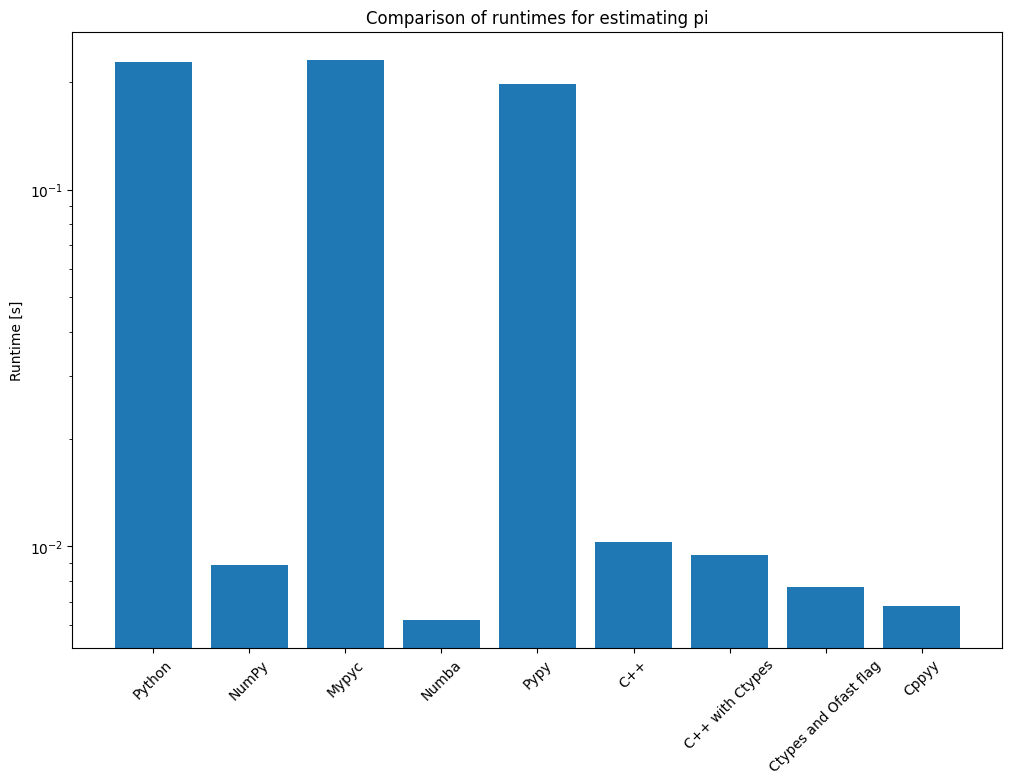

In [11]:
import matplotlib.pyplot as plt

runtimes = {
    "Python": 0.2276096250000137,
    "NumPy": 0.008878167000148096,
    "Mypyc": 0.23136049999993702,
    "Numba": 0.006228624999494059,
    "Pypy": 0.198,
    "C++": 0.010273,
    "C++ with Ctypes": 0.009439458000997547,
    "Ctypes and Ofast flag": 0.007690166999964276,
    "Cppyy": 0.006816166001954116,
}

names = list(runtimes.keys())
times = list(runtimes.values())

plt.figure(figsize=(12, 8))
plt.title("Comparison of runtimes for estimating pi")
plt.bar(range(len(times)), times, log=True)
plt.xticks(range(len(times)), names, rotation=45)
plt.ylabel("Runtime [s]")
plt.show()

Note that this is a logarithmic plot. We can see that methods such as Mypyc and Pypy did not give a significant speed-up compared to the other methods, but we need to consider that this was a very specific example problem, and it is not unthinkable that these methods could fare better in other situations.